Used for examining structures, parameters, and costs of trees generated by the symbolic regression code

# Imports

In [1]:
import h5py
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Setup

In [2]:
from scipy.interpolate import CubicSpline

def plotSpline(y):
    x = np.arange(len(y)-2)
    
    spline = CubicSpline(x, y[:-2], bc_type=((1, y[-2]), (1, y[-1])))
    
    sampleX = np.linspace(x[0], x[-1], 100)
    sampleY = spline(sampleX)
    
    return sampleX, sampleY

In [3]:
files = glob.glob('results/tree*')
argsort = np.argsort([int(s[s.find('_')+1:s.find('.pkl')]) for s in files])

treeFile  = np.array(glob.glob('results/tree*'))[argsort][-1]
errorFile = np.array(glob.glob('results/errors*'))[argsort][-1]

tree = pickle.load(open(treeFile, 'rb'))
errors = pickle.load(open(errorFile, 'rb'))

print('treeFile:', treeFile)

treeFile: results/tree_180.pkl


# Examine Tree

In [4]:
print(tree)

sqrt(inv(mul(inv(rho), sqrt(ffg))))


In [5]:
tree.bestParams.shape

(27,)

In [6]:
splits = []
for svNode in tree.svNodes:
    for comp in svNode.components:
        splits.append(svNode.numParams[comp] + len(svNode.restrictions[comp]))
        
splits = np.cumsum(splits)[:-1]

In [7]:
splitParams = np.split(tree.bestParams, splits)

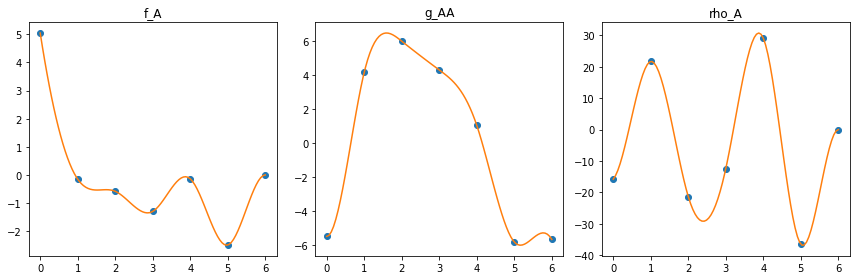

In [8]:
n = len(splitParams)

nrows = n//3
ncols = 3

fxnNames = [n.components for n in tree.svNodes]
fxnNames = [name for sublist in fxnNames for name in sublist]

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4))


# NOTE: I'm not sure this is labeling the functions correctly
for i, (node, params) in enumerate(zip(fxnNames, splitParams)):
    row = i//3; col = i%3
    
    if nrows > 1:
        ax = axes[row][col]
    else:
        ax = axes[col]
        
    sampleX, sampleY = plotSpline(params)
    
    ax.plot(np.arange(len(params)-2), params[:-2], 'o')
    ax.plot(sampleX, sampleY)
    ax.set_title(node.decode('utf8'))
    

plt.tight_layout()

# Examine energies/forces

In [9]:
print('Total error:', sum(errors))

Total error: 286.533584282269


In [13]:
databasePath = '/home/jvita/scripts/svreg_data/mlearn/Mo/Mo.hdf5'
refStruct = 'Ground_state_crystal'

print(
    '{:>60} || {}, {}\n'.format(
        '<structName>',
        '<energyError> (eV)',
        '<forceErrors> (eV/A)'
    )
)

with h5py.File(databasePath, 'r') as database:
    for i, structName in enumerate(sorted(database.keys())):
        compEng = errors[i]
        compFcs = errors[2*i]
        
        print(
            '{:>60} || {:.6f}, {:.6f}'.format(
                structName,
                compEng,
                compFcs
            )
        )

                                                <structName> || <energyError> (eV), <forceErrors> (eV/A)

                                        Ground_state_crystal || 0.000000, 0.000000
                         Mo_3x3x3_cell_mode_1_strain_-0.0200 || 1.144047, 0.604684
                         Mo_3x3x3_cell_mode_1_strain_-0.0400 || 0.604684, 0.654130
                         Mo_3x3x3_cell_mode_1_strain_-0.0600 || 0.253982, 0.323897
                         Mo_3x3x3_cell_mode_1_strain_-0.0800 || 0.654130, 0.288456
                         Mo_3x3x3_cell_mode_1_strain_-0.1000 || 0.516741, 1.227638
                          Mo_3x3x3_cell_mode_1_strain_0.0200 || 0.323897, 1.077612
                          Mo_3x3x3_cell_mode_1_strain_0.0800 || 0.913593, 0.405874
                         Mo_3x3x3_cell_mode_2_strain_-0.0200 || 0.288456, 0.606108
                         Mo_3x3x3_cell_mode_2_strain_-0.0400 || 0.493902, 0.655061
                         Mo_3x3x3_cell_mode_2_strain_-0.0600 || 